In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report, precision_recall_curve
)
from imblearn.over_sampling import SMOTE

In [235]:
#loading Dataset
df = pd.read_csv("diabetic_data.csv")
#Target
df["readmitted_flag"] = df["readmitted"].replace({"<30":1, ">30":0, "NO":0})

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\419055726.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["readmitted_flag"] = df["readmitted"].replace({"<30":1, ">30":0, "NO":0})


C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\695568992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df["readmitted_text"], palette="magma")


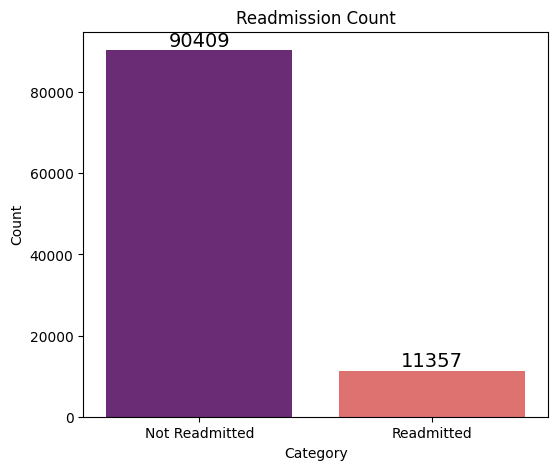

In [236]:
df['readmitted_text'] = df['readmitted_flag'].map({0: "Not Readmitted", 1: "Readmitted"})

plt.figure(figsize=(6,5))
ax = sns.countplot(x=df["readmitted_text"], palette="magma")

for p in ax.patches:
    ax.annotate(
    f"{p.get_height():.0f}",      # rounds float to integer-looking number
    (p.get_x() + p.get_width()/2., p.get_height()),
    ha='center', va='bottom', fontsize=14
)


plt.title("Readmission Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


In [237]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


In [238]:
df.shape

(101766, 52)

In [239]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [240]:
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
readmitted_text 0


In [241]:
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count()) 

gender 3


In [242]:
df = pd.read_csv("diabetic_data.csv")
df = df.replace("?", np.nan)
df = df[df["discharge_disposition_id"] != 11]
df = df[df["gender"] != "Unknown/Invalid"]
df = df.sort_values("encounter_id").drop_duplicates("patient_nbr", keep="first")

In [243]:
med_cols = [
    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
    'acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone',
    'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide',
    'insulin','glyburide-metformin',
    'glipizide-metformin','glimepiride-pioglitazone',
    'metformin-rosiglitazone','metformin-pioglitazone'
]

df['medication_count'] = (df[med_cols] != 'No').sum(axis=1)
df['med_changes'] = (df[med_cols].isin(['Up', 'Down'])).sum(axis=1)
df['insulin_changed'] = df['insulin'].apply(lambda x: 1 if x in ['Up','Down'] else 0)
df['emergency_admission'] = df['admission_type_id'].apply(lambda x: 1 if x==1 else 0)


# 9. HbA1c risk score
df['A1C_risk'] = df['A1Cresult'].map({'None':0, 'Norm':1, '>7':2, '>8':3})

# 10. Glucose test score
df['glucose_risk'] = df['max_glu_serum'].map({'None':0, 'Norm':1, '>200':2, '>300':3})


In [244]:
# Drop useless/missing columns
cols_to_drop = [
    "weight", "payer_code", "medical_specialty",
    "max_glu_serum", "A1Cresult", 
    "encounter_id", "patient_nbr",'examide','citoglipton'
]

In [245]:
#Target
df["readmitted_flag"] = df["readmitted"].replace({"<30":1, ">30":0, "NO":0})

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\1423684192.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["readmitted_flag"] = df["readmitted"].replace({"<30":1, ">30":0, "NO":0})


In [246]:
# Age midpoint
age_map = {"[0-10)":5, "[10-20)":15, "[20-30)":25, "[30-40)":35,
           "[40-50)":45, "[50-60)":55, "[60-70)":65, "[70-80)":75,
           "[80-90)":85, "[90-100)":95}
df["age_num"] = df["age"].map(age_map)


In [247]:
# ICD grouping
def group_icd(code):
    if pd.isna(code): return "Unknown"
    code = str(code)
    if code.startswith("V"): return "Supplementary"
    if code.startswith("E"): return "External"
    try:
        num = int(code.split(".")[0])
    except:
        return "Other"
    if num == 250: return "Diabetes"
    if 390 <= num <= 459 or num == 785: return "Circulatory"
    if 460 <= num <= 519 or num == 786: return "Respiratory"
    if 520 <= num <= 579 or num == 787: return "Digestive"
    if 580 <= num <= 629 or num == 788: return "Genitourinary"
    if 780 <= num <= 799: return "Symptoms"
    if 240 <= num <= 279: return "Endocrine"
    if 1 <= num <= 139: return "Infectious"
    if 800 <= num <= 999: return "Injury"
    return "Other"

df["diag1_group"] = df["diag_1"].apply(group_icd)
df["diag2_group"] = df["diag_2"].apply(group_icd)
df["diag3_group"] = df["diag_3"].apply(group_icd)

In [248]:
# Charlson Comorbidity Index (simplified version)
# -----------------------------
def charlson_icd(code):
    if pd.isna(code): return 0
    code = str(code)
    try:
        num = int(code.split(".")[0])
    except:
        return 0
    # Assign weights based on Charlson comorbidity categories
    if num == 250: return 1    # Diabetes
    if 390 <= num <= 459 or num == 785: return 1  # Cardiovascular
    if 410 <= num <= 414: return 1  # Myocardial infarction
    if 430 <= num <= 438: return 1  # Stroke
    if 140 <= num <= 239: return 2  # Cancer
    if 580 <= num <= 629 or num == 585: return 1  # Renal
    if 240 <= num <= 279: return 1  # Endocrine
    if 480 <= num <= 486: return 1  # Pneumonia
    return 0

df["cci_diag1"] = df["diag_1"].apply(charlson_icd)
df["cci_diag2"] = df["diag_2"].apply(charlson_icd)
df["cci_diag3"] = df["diag_3"].apply(charlson_icd)
df["cci_total"] = df[["cci_diag1","cci_diag2","cci_diag3"]].sum(axis=1)

In [249]:
# Prior utilization
df["total_visits"] = df["number_outpatient"] + df["number_inpatient"] + df["number_emergency"]

In [250]:
# Comorbidity
df["comorbidity_count"] = df["number_diagnoses"]

In [251]:
# Diabetes medication & polypharmacy
df["diabetesMed_flag"] = df["diabetesMed"].replace({"Yes":1, "No":0})
df["polypharmacy"] = (df["num_medications"] > 7).astype(int)
df["age_poly"] = df["age_num"] * df["polypharmacy"]
df["visits_per_day"] = df["total_visits"] / df["time_in_hospital"].replace(0, 1)


C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\2680516733.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["diabetesMed_flag"] = df["diabetesMed"].replace({"Yes":1, "No":0})


In [252]:
# 3. Features & Target
features = [
    "age_num", "gender", "race",
    "diag1_group", "diag2_group", "diag3_group",
    "polypharmacy", "diabetesMed_flag",
    "total_visits", "comorbidity_count",
    "num_medications", "num_lab_procedures",'age_poly',"visits_per_day",
    "time_in_hospital",'medication_count','med_changes','insulin_changed','emergency_admission',
    "cci_total"
]
X = df[features]
y = df["readmitted_flag"]


In [253]:
# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [254]:
# 5. Preprocessing: Encode & Scale
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ]
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [255]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_proc, y_train)

In [256]:
# Logistic Regrssion

log = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
log.fit(X_train_bal, y_train_bal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,5000
,multi_class,'deprecated'


In [257]:
#random Forest
rf = RandomForestClassifier(
    n_estimators=500, max_depth=15, min_samples_split=5,
    min_samples_leaf=2, class_weight="balanced", random_state=42, n_jobs=-1
)
rf.fit(X_train_bal, y_train_bal)

,n_estimators,500
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [258]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    max_depth=10, min_samples_leaf=5,
    class_weight="balanced", random_state=42
)
dt.fit(X_train_bal, y_train_bal)


,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [259]:
# Lightgbm

from lightgbm import early_stopping, log_evaluation
lgbm = LGBMClassifier(
    n_estimators=1000, max_depth=12, num_leaves=31,
    learning_rate=0.05, colsample_bytree=0.8, subsample=0.8,
    class_weight="balanced", random_state=42
)
lgbm.fit(X_train_bal, y_train_bal, eval_set=[(X_test_proc, y_test)], eval_metric="auc",
         callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)])

[LightGBM] [Info] Number of positive: 51317, number of negative: 51317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13187
[LightGBM] [Info] Number of data points in the train set: 102634, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.604225	valid_0's binary_logloss: 0.298683


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,12
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [260]:

from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=3,
    random_state=42
)
xgb.fit(X_train_bal, y_train_bal)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [261]:
# 8. Evaluation Function

def evaluate(model, X_test, y_test, threshold=0.5, name="Model"):
    prob = model.predict_proba(X_test)[:,1]
    pred = (prob >= threshold).astype(int)
    
    print(f"\n {name} (Threshold={threshold})")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall:", recall_score(y_test, pred))
    print("F1:", f1_score(y_test, pred))
    print("ROC-AUC:", roc_auc_score(y_test, prob))
    print("PR-AUC:", average_precision_score(y_test, prob))
    print(classification_report(y_test, pred))


In [262]:
# 9. Threshold Optimization

def best_threshold(model, X_test, y_test):
    prob = model.predict_proba(X_test)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx] if best_idx < len(thresholds) else 0.5


In [263]:
# 10. Evaluate Models

for model, name in zip([log, rf, lgbm,dt,xgb], ["Logistic Regression", "Random Forest", "LightGBM","Decision Tree","Xboost Classifier"]):
    thresh = best_threshold(model, X_test_proc, y_test)
    evaluate(model, X_test_proc, y_test, threshold=thresh, name=name)


 Logistic Regression (Threshold=0.4741679011654746)
Accuracy: 0.5097593867556249
Precision: 0.10929717764250138
Recall: 0.6274821286735505
F1: 0.18616707906209498
ROC-AUC: 0.5839674685212688
PR-AUC: 0.11360997497592892
              precision    recall  f1-score   support

           0       0.93      0.50      0.65     12830
           1       0.11      0.63      0.19      1259

    accuracy                           0.51     14089
   macro avg       0.52      0.56      0.42     14089
weighted avg       0.86      0.51      0.61     14089


 Random Forest (Threshold=0.24274012691433644)
Accuracy: 0.45993328128327066
Precision: 0.10831482852208241
Recall: 0.6973788721207307
F1: 0.18750667378537106
ROC-AUC: 0.5902152978678225
PR-AUC: 0.11418266246636131
              precision    recall  f1-score   support

           0       0.94      0.44      0.60     12830
           1       0.11      0.70      0.19      1259

    accuracy                           0.46     14089
   macro avg       

C:\Users\AJ017541\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\AJ017541\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 LightGBM (Threshold=0.12098739981362139)
Accuracy: 0.6233231599119881
Precision: 0.12083177219932559
Recall: 0.5123113582208102
F1: 0.19554342883128695
ROC-AUC: 0.6042252291683821
PR-AUC: 0.12857689906493103
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     12830
           1       0.12      0.51      0.20      1259

    accuracy                           0.62     14089
   macro avg       0.53      0.57      0.47     14089
weighted avg       0.86      0.62      0.70     14089


 Decision Tree (Threshold=0.1942257217847769)
Accuracy: 0.49265384342394775
Precision: 0.10396772024209819
Recall: 0.613979348689436
F1: 0.1778237865194387
ROC-AUC: 0.565503681366337
PR-AUC: 0.10923343047696063
              precision    recall  f1-score   support

           0       0.93      0.48      0.63     12830
           1       0.10      0.61      0.18      1259

    accuracy                           0.49     14089
   macro avg       0.52      0.55

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\3369413533.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp, palette="viridis")


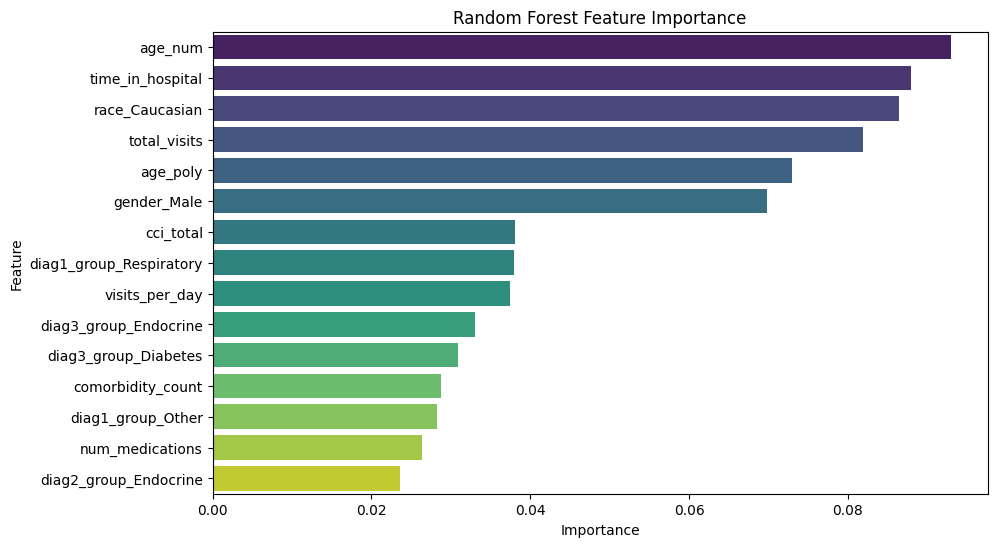

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\3369413533.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp, palette="viridis")


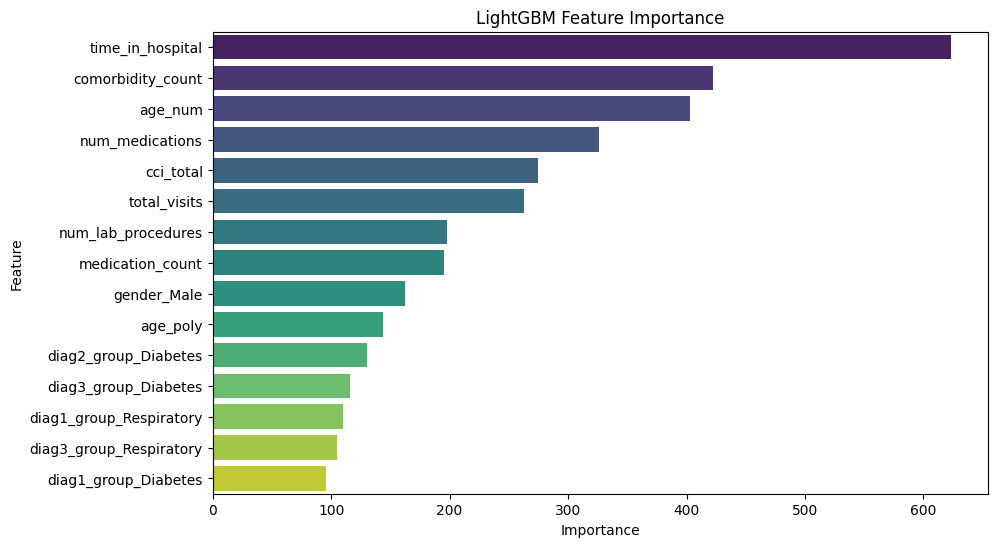

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\3369413533.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp, palette="viridis")


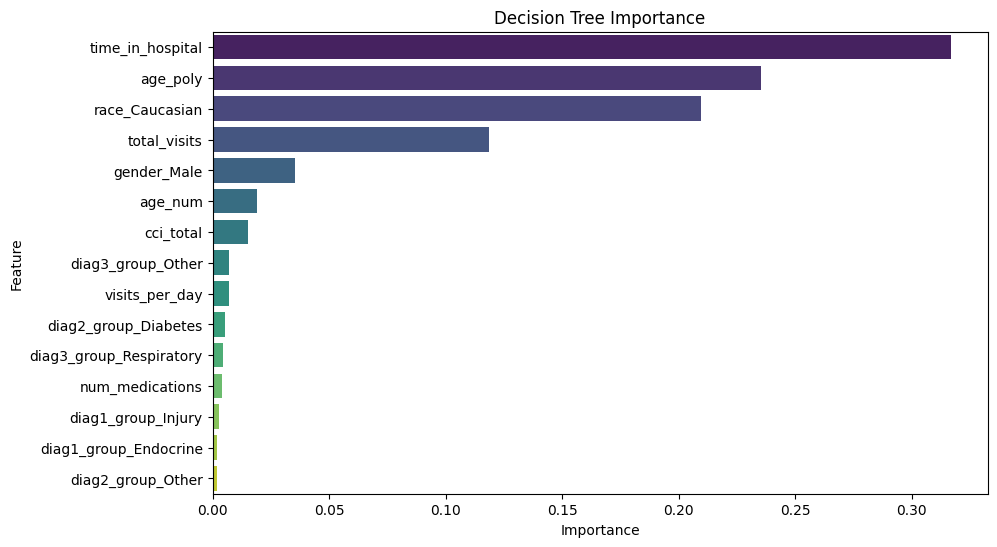

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\3369413533.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp, palette="viridis")


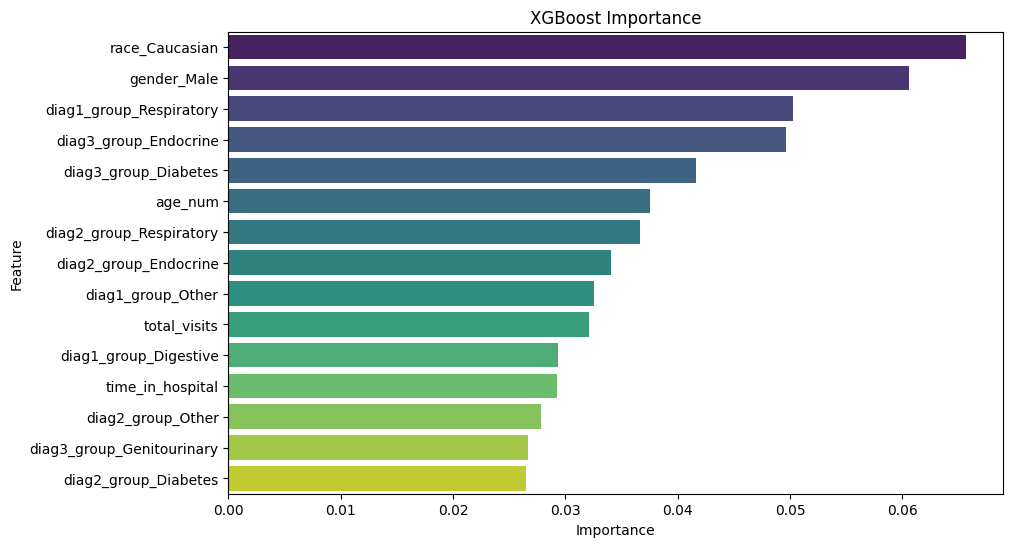

C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\3369413533.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=df_imp, palette="viridis")


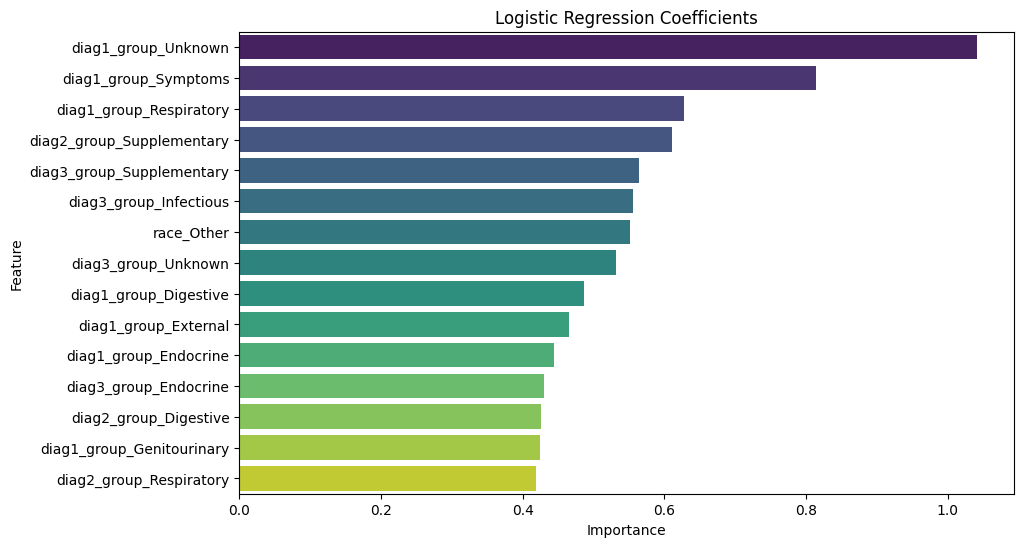

In [264]:
def plot_feature_importance(model, feature_names, top_n=15, title="Feature Importance"):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
    else:
        print("No feature importance available")
        return
    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(top_n)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=df_imp, palette="viridis")
    plt.title(title)
    plt.show()

ohe_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

plot_feature_importance(rf, all_feature_names, title="Random Forest Feature Importance")
plot_feature_importance(lgbm, all_feature_names, title="LightGBM Feature Importance")
plot_feature_importance(dt, all_feature_names, title="Decision Tree Importance")
plot_feature_importance(xgb, all_feature_names, title="XGBoost Importance")
plot_feature_importance(log, all_feature_names, title="Logistic Regression Coefficients")


C:\Users\AJ017541\AppData\Local\Temp\ipykernel_22832\695568992.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df["readmitted_text"], palette="magma")


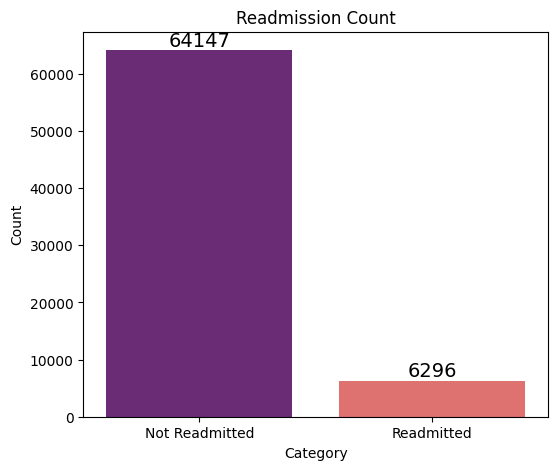

In [265]:
df['readmitted_text'] = df['readmitted_flag'].map({0: "Not Readmitted", 1: "Readmitted"})

plt.figure(figsize=(6,5))
ax = sns.countplot(x=df["readmitted_text"], palette="magma")

for p in ax.patches:
    ax.annotate(
    f"{p.get_height():.0f}",      # rounds float to integer-looking number
    (p.get_x() + p.get_width()/2., p.get_height()),
    ha='center', va='bottom', fontsize=14
)


plt.title("Readmission Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()
